[View in Colaboratory](https://colab.research.google.com/github/agerk/dataScience/blob/master/naive_bayes_ensembles_nn_model_python.ipynb)

<h2>Naive Bayes Classifier</h2>
- called naive because informally, the make the simplifying assumption that each feature on an instance is conditionally independer of all other
    - assume no correlation between features
- probabilitic classifier family
- highly effieicent learning and prediction
- generalizatio performance may worse than more sophisticated learning methods-- this is the penenality for assuming no correlation
- for high dimensional data sets, it can achive competitive perfornamce, like SVM
- comes in three flavour, in Scikit Leanr
    - Bernoulli: binary features -- text classification
    - Multinomial: discrete features -- word count
    - Gaussian: continous/real-valued features 


In [0]:
%matplotlib notebook
# %matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
# from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

In [0]:
# Load data
def load_crime_dataset():
#     path = 'https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized'
    df_crime = pd.read_table('/Users/AD/Downloads/CommViolPredUnnormalizedData.txt', sep=',', na_values='?')
    # remove features with poor coverate
    columns_to_keep = [5, 6] + list(range(11,26))+ list(range(32, 103)) + [145]
    df_crime = df_crime.iloc[:, columns_to_keep].dropna()
    
    X_crime = df_crime.iloc[:,range(0,88)]
    y_crime = df_crime['ViolentCrimesPerPop']
    return (X_crime, y_crime)

def load_fruit_dataset():
    fruits = pd.read_table('/Users/AD/Downloads/fruit_data_with_colors.txt')
    feature_names_fruits = ['height', 'width', 'mass', 'color_score']
    X_fruits = fruits[feature_names_fruits]
    y_fruits = fruits['fruit_label']
    target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']
    
    X_fruits_2d = fruits[['height', 'width']]
    y_fruits_2d = fruits['fruit_label']
    
    return (X_fruits, y_fruits, X_fruits_2d, y_fruits_2d)


Create utility functions for plotting

In [0]:

def plot_class_regions_subplot(clf, X, y, X_test, y_test, title, 
                               subplot, target_names=None, 
                               plot_decision_regions=True):
    """
    Args: classification , train and test dataset, subplot
    Returns: classification plot by region
    """
    numClasses = numpy.amax(y)+1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])
    
    # set fig size
    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50
    
    # set plot boundary
    x_min = X[:,0].min()
    x_max = X[:,0].max()
    y_min = X[:,1].min()
    y_max = X[:,1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), 
                            numpy.arange(y_min-k,y_max+k,h))
    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    
    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha=0.8)
    
    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)
    
    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)

<h3>Gaussian Naive Bayes Classifiers</h3>

- in general the decision boundary is a `parabolic curve` between classes 
- the special case is when the variance of two features is same for classes, the decision boundary will be `linear`
- Navie Bayes models are a few classifier that supports `partial fit` in `Scikit Learn` -- can be used to train model if data doensn't fit into memeory




<IPython.core.display.Javascript object>


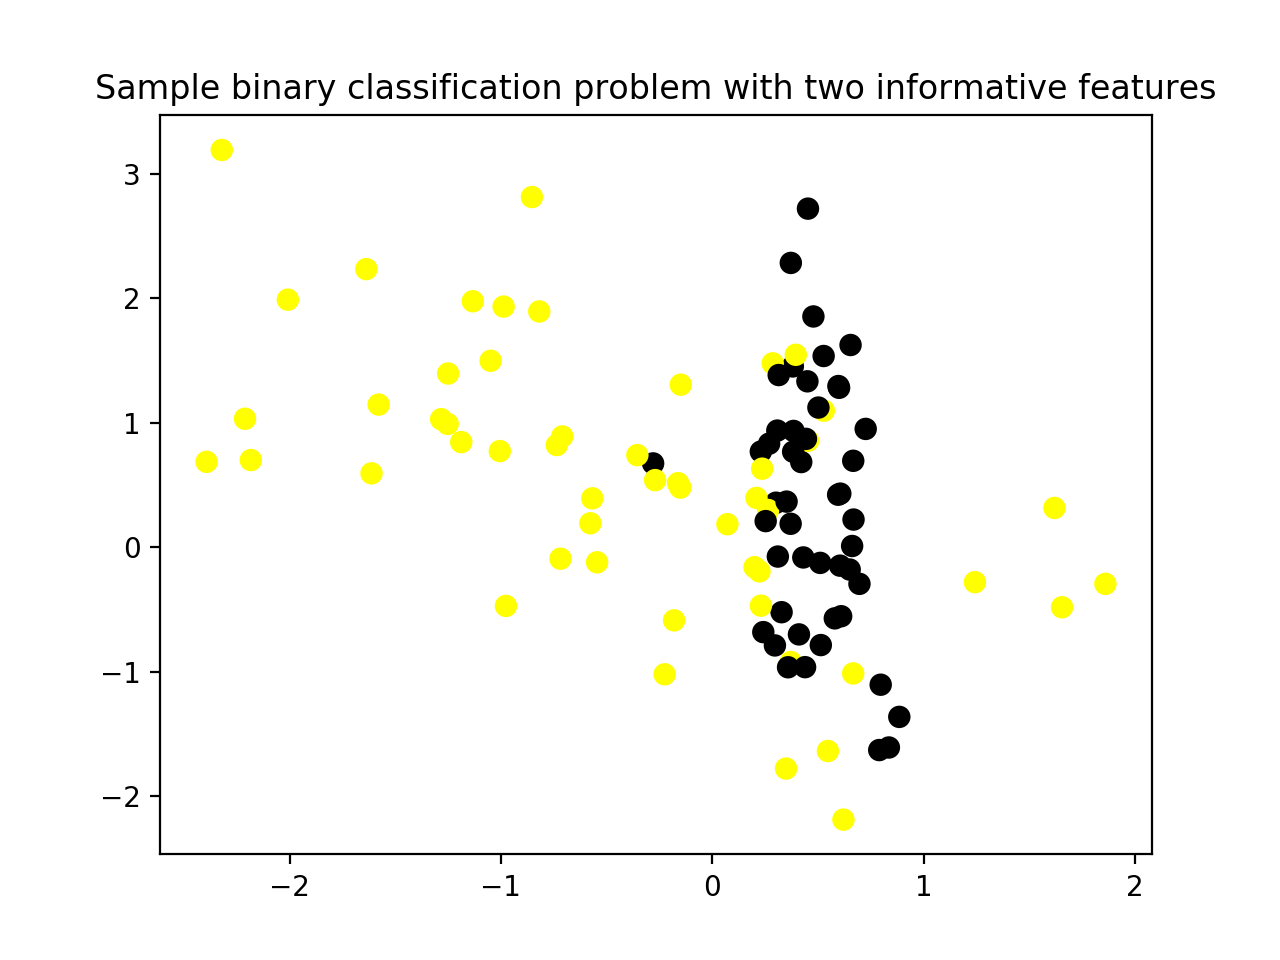

<IPython.core.display.Javascript object>


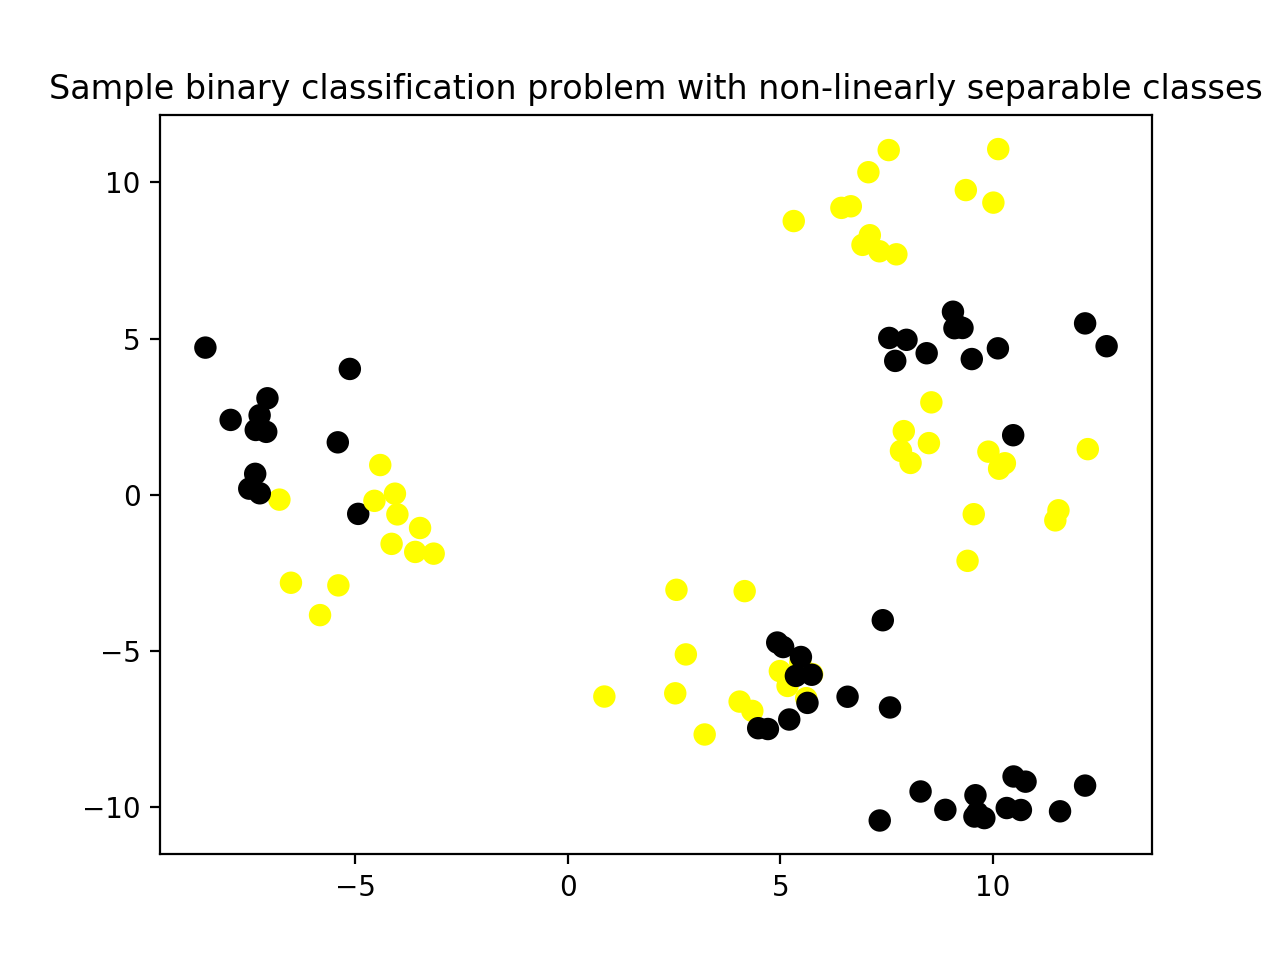

In [0]:
cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])
# make synthetic dataset for a binary classification
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples=100, n_features=2,
                                 n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y=0.1,
                                class_sep=0.5, random_state=0)

plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o',c=y_C2, s=50, cmap=cmap_bold)

plt.show()

# non-linearly separable classes
X_D2, y_D2 = make_blobs(n_samples=100, n_features=2, 
                        centers=8, cluster_std=1.3,
                        random_state=4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker='o', s=50, cmap=cmap_bold)
plt.show()

In [0]:
def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

<IPython.core.display.Javascript object>


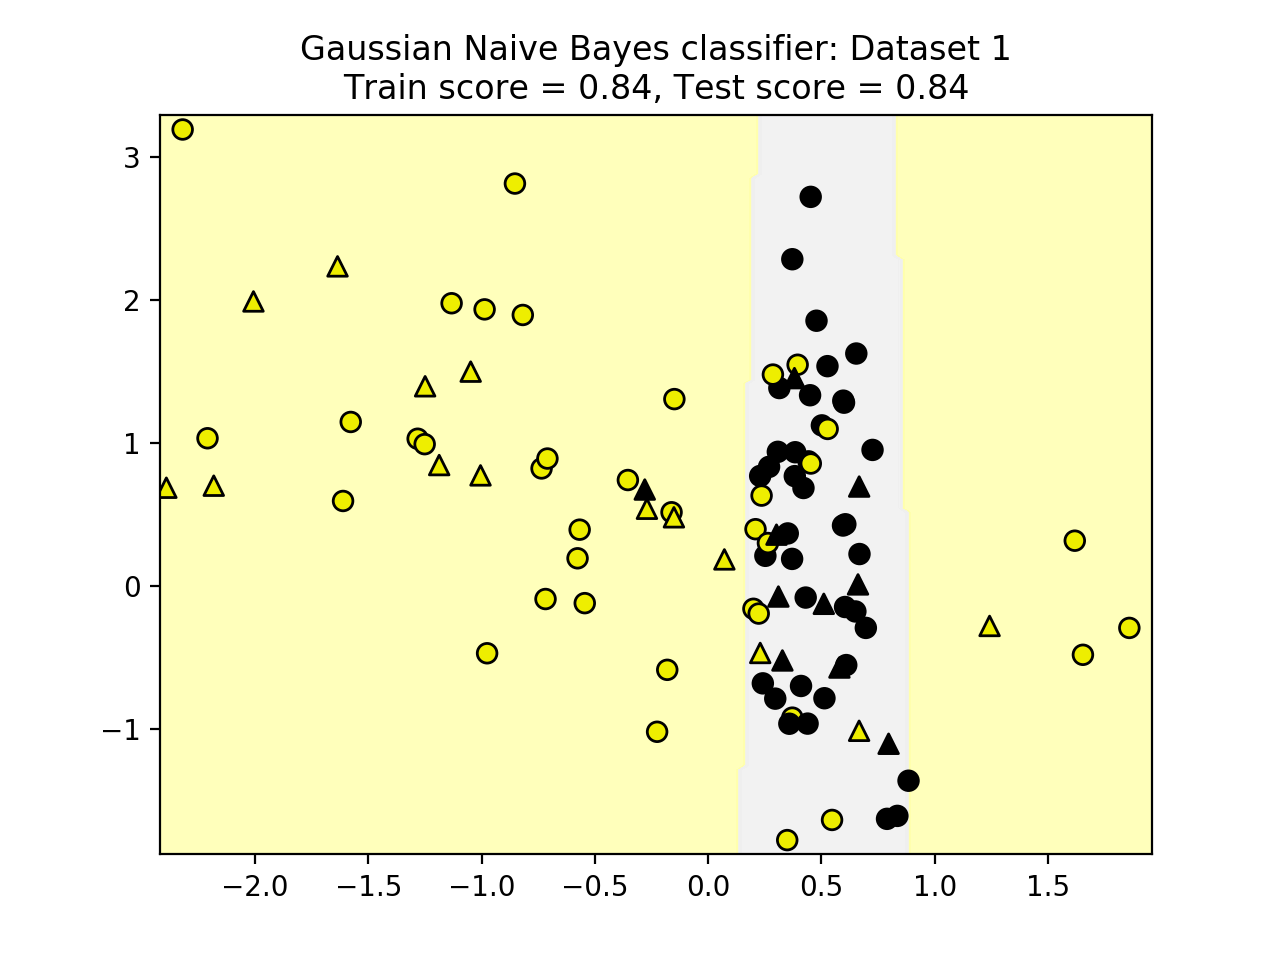

In [0]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)
nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 1')

<IPython.core.display.Javascript object>


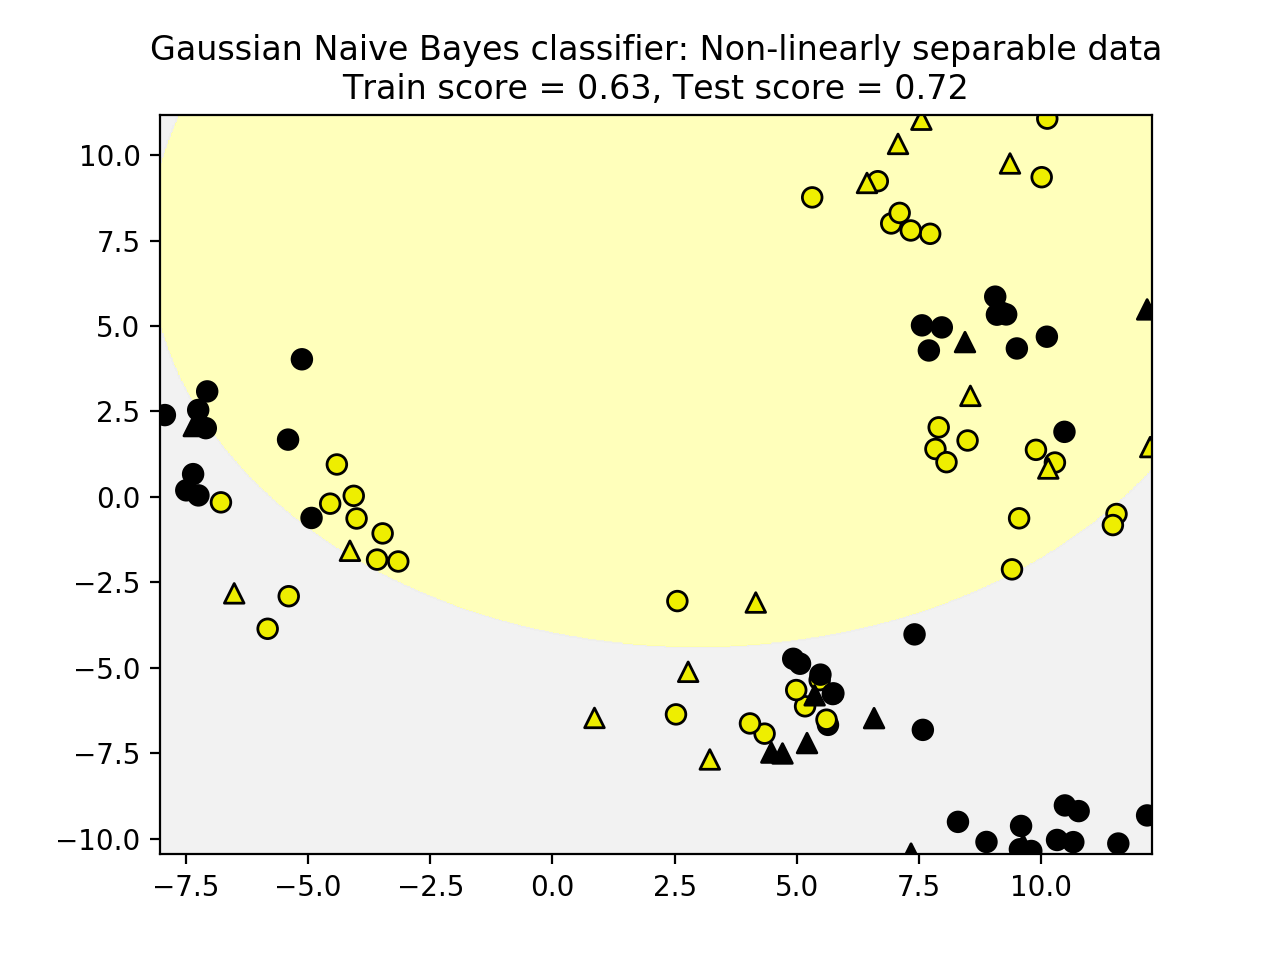

In [0]:
# Native Bayes for dataset 2: 
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state=0)
nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Non-linearly separable data')

<h3>Application example for real-world dataset</h3>

In [0]:
# get cancer dataset
# Breast cancer dataset for classification
cancer = load_breast_cancer()
X_cancer, y_cancer = load_breast_cancer(return_X_y = True)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

# fit and train model
nbclf_cancer = GaussianNB().fit(X_train, y_train)
print('Breast cancer dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf_cancer.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf_cancer.score(X_test, y_test)))


Breast cancer dataset
Accuracy of GaussianNB classifier on training set: 0.95
Accuracy of GaussianNB classifier on test set: 0.94


<h2>Ensembles of Decision Trees</h2>

- produce more powerful aggregate model than each individual model
- by ensebling individual model mistakes would be averaged out

<h3>Random Forests</h3>

- an ensemble of tree, not just one tree
- widely used in practice for supervised learning
- `sklearn` supports for both classification and regression
- One decision tree --> prone to overfitting
- Many decision trees --> more stable and better generalization
- ensemble of tree should be diverse-- introduce random variation into tree-building
- random variation in tree building involves two steps:
    - data used for building the tree is randomly selected
    - trees are built from different random sample by `bootstraping`in parallel
- learning is quite sensitive to `max_features`
    - setting `max_features = 1` leads to forset with complex trees
    - setting `max_features = < close to number of features` will lead to simillar forests simpler trees

**Pros**:
- no feature scaling is required
- scalable

**Cons**:
- difficult for interpretation 
- not suitable for high dimensional (sparse) data

<h3>Prediction</h3>
- make prediction for every tree
- combine individual predictions
    - Regression: mean of individual tree prediction
    - Classification: probabilities averaged across trees-- predict class with highest prob


<IPython.core.display.Javascript object>


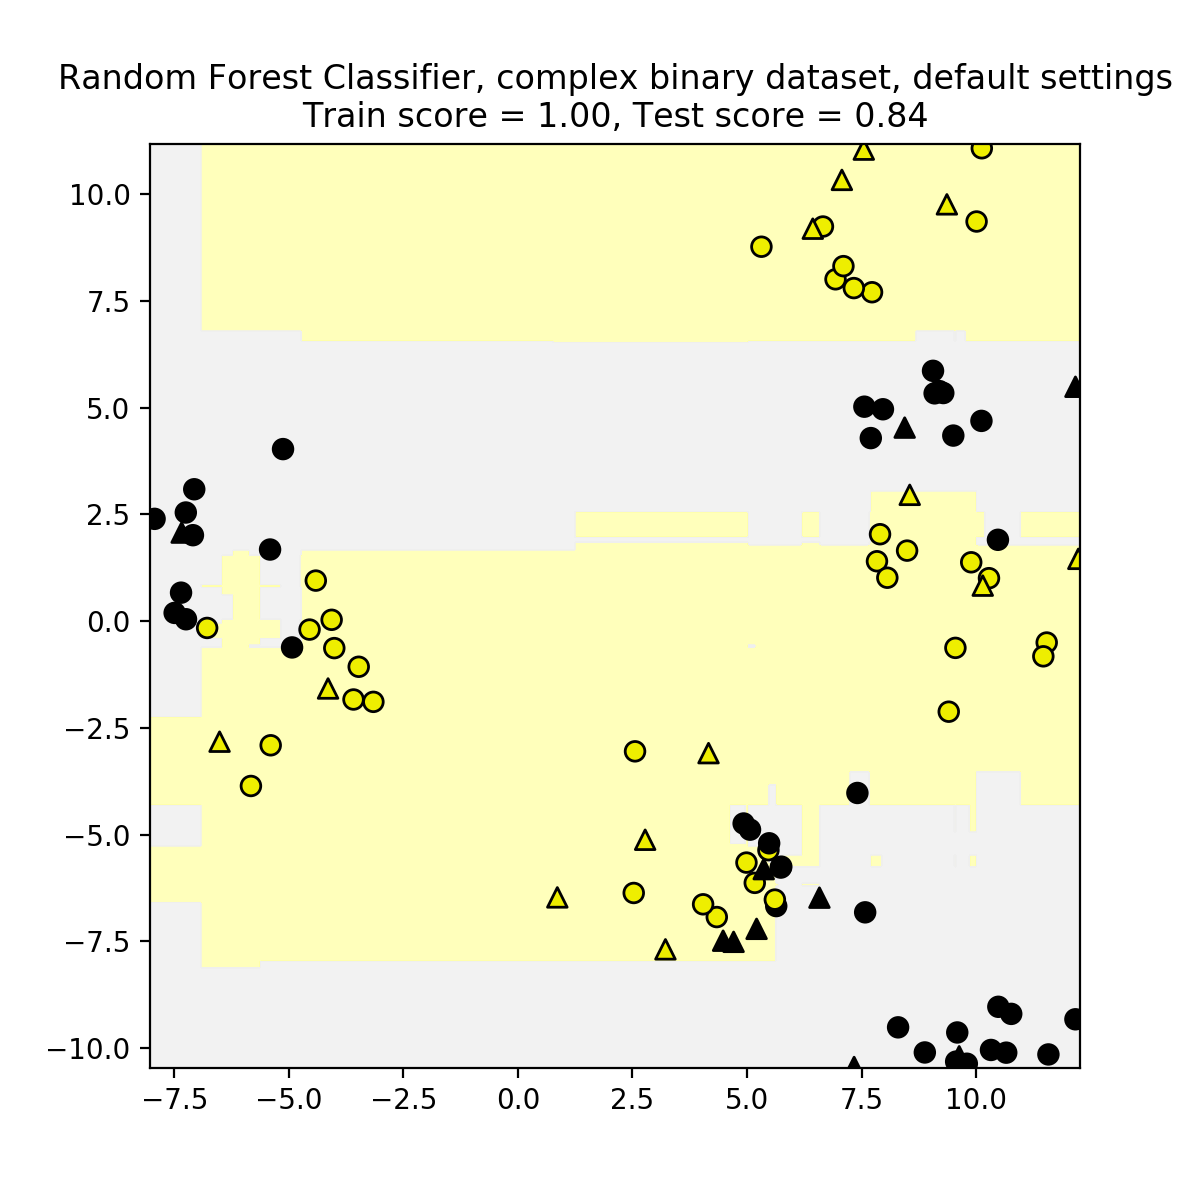

In [0]:
# Random Forest on the Fruit dataset

from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

rf = RandomForestClassifier().fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_subplot(rf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

<IPython.core.display.Javascript object>


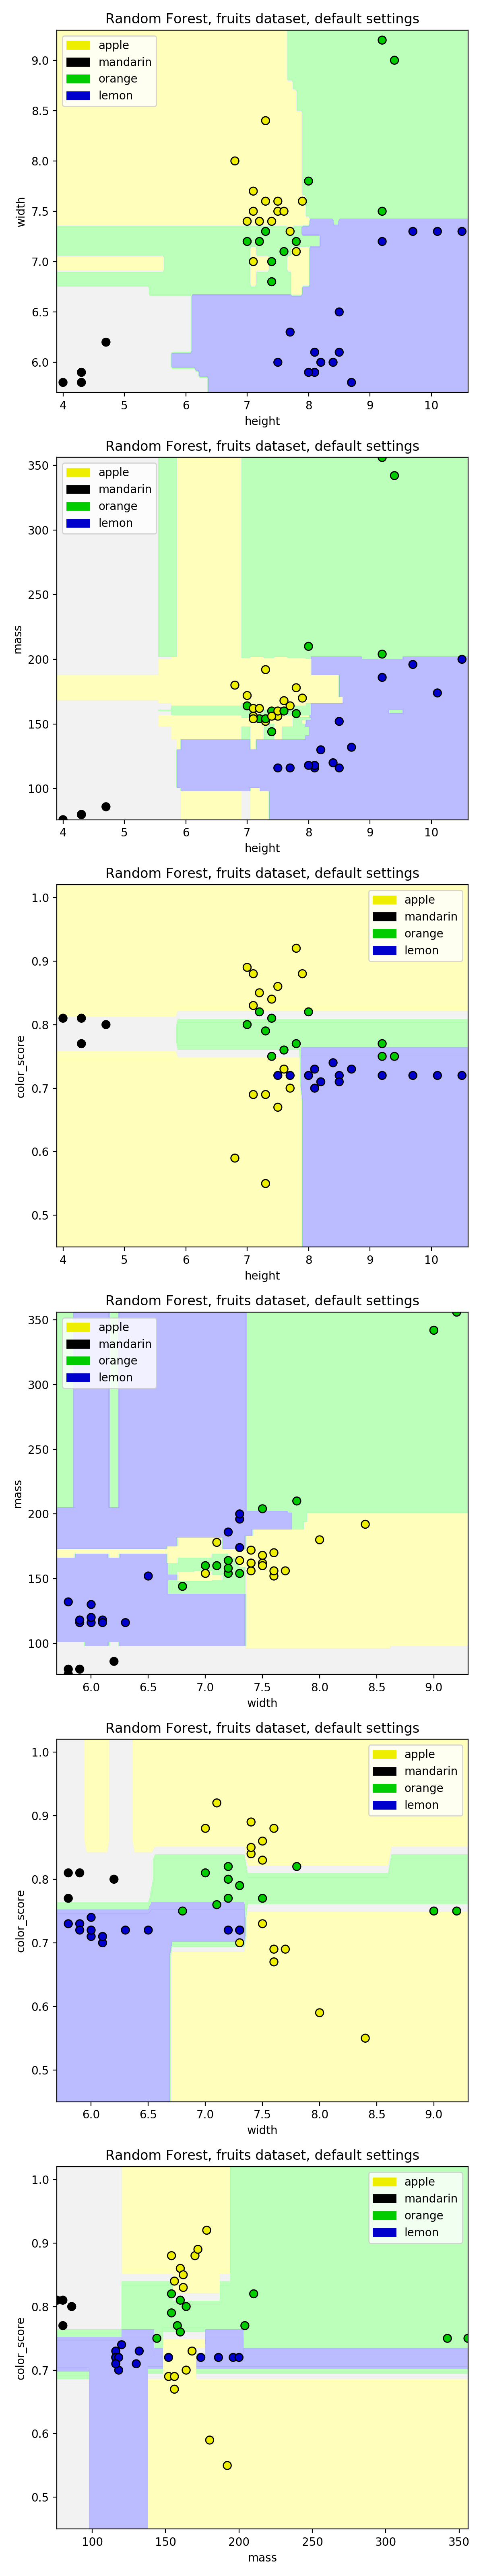

Random Forest, Fruit dataset, default settings
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80


In [0]:
# Random Forest: Fruid dataset
# load Fruits data
X_fruits, y_fruits, X_fruits_2d, y_fruits_2d = load_fruit_dataset()
X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
feature_names_fruits = ['height', 'width', 'mass', 'color_score']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    rf = RandomForestClassifier().fit(X, y)
    plot_class_regions_subplot(rf, X, y, None,
                                None, title, axis,
                                target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()

rf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))
plt.show()

In [0]:
# Random Forest on a real-world dataset

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = RandomForestClassifier(max_features = 8, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.99


<h2>Gradient Boosted Decision Trees (GBDT)</h2>

- use ensemble of multiple trees
- buidld weak learner in series in a non-random way
- each tree attepts to correct errors from the previous stage
- doesn't use lot of memeory

**Pros**:
 - best off-the-shelf accuracy on many problems
 - prediction requires less memorey
 - doesnt require careful feature normalization
 - handles mixture of features data types

**Cons**:
 - hard to interpret result
 - require tuning of `learning rate`
 - traiing require significant computation
 - not recommended for text classification and other high dimenstional sparse features

** key parameters for model control**
 - learninf rate: 
      - high `learning rate`: more complex model
      - low `learning rate`: simpler trees
      -  `n_estimators`: sets the number of small decision trees to use in the ensemble
      -  `max_depth`: is typically set to a small value between [3-5] for most applications

<IPython.core.display.Javascript object>


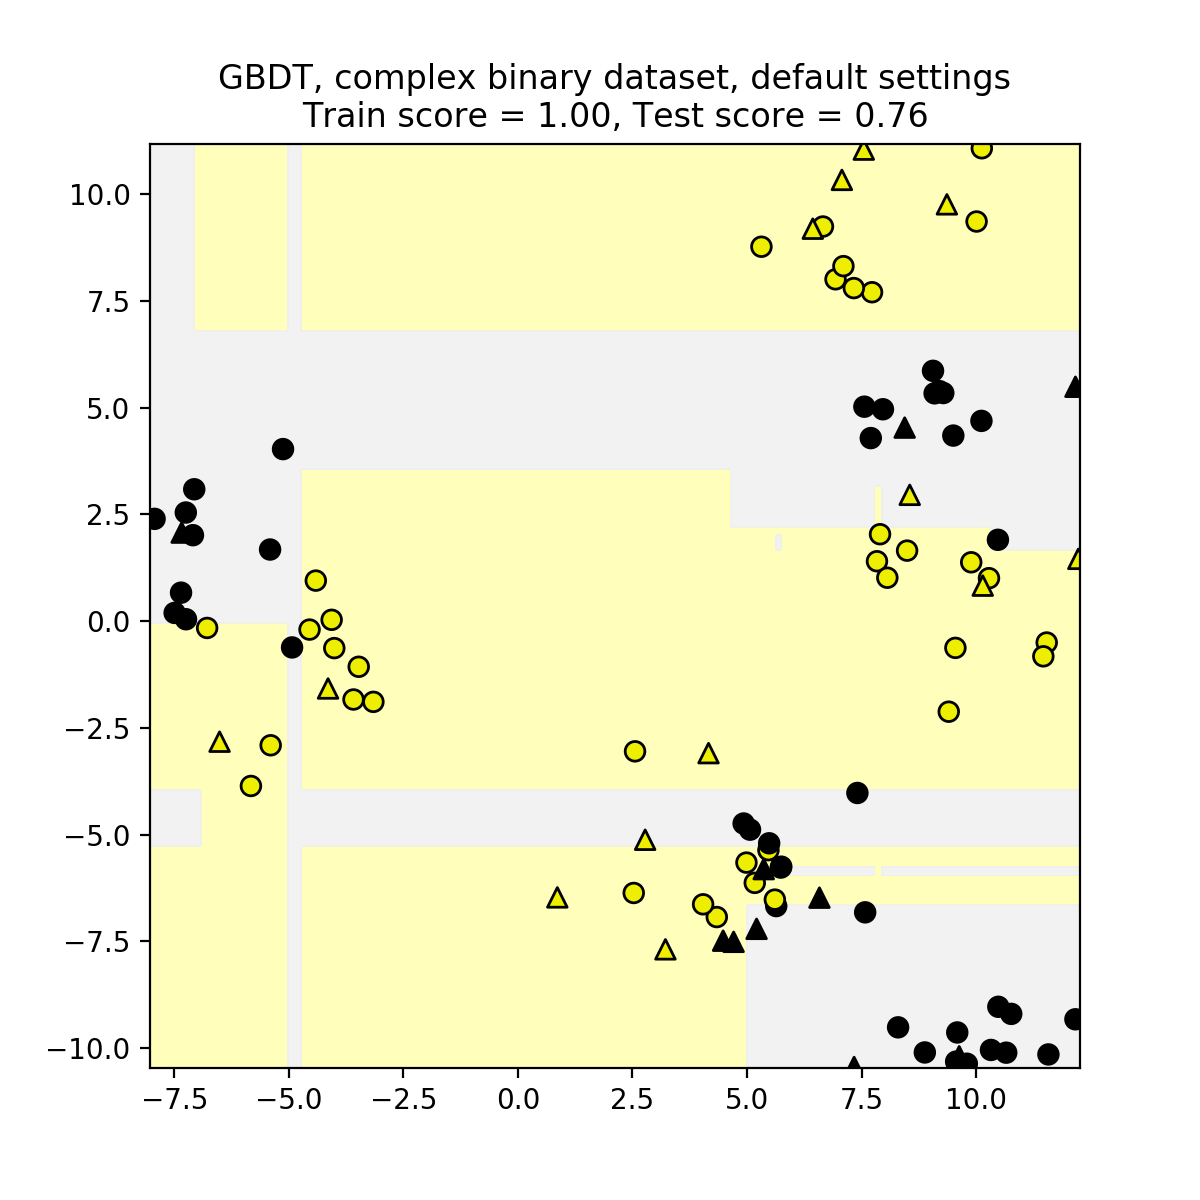

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = GradientBoostingClassifier().fit(X_train, y_train)
title = 'GBDT, complex binary dataset, default settings'
plot_class_regions_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

<IPython.core.display.Javascript object>


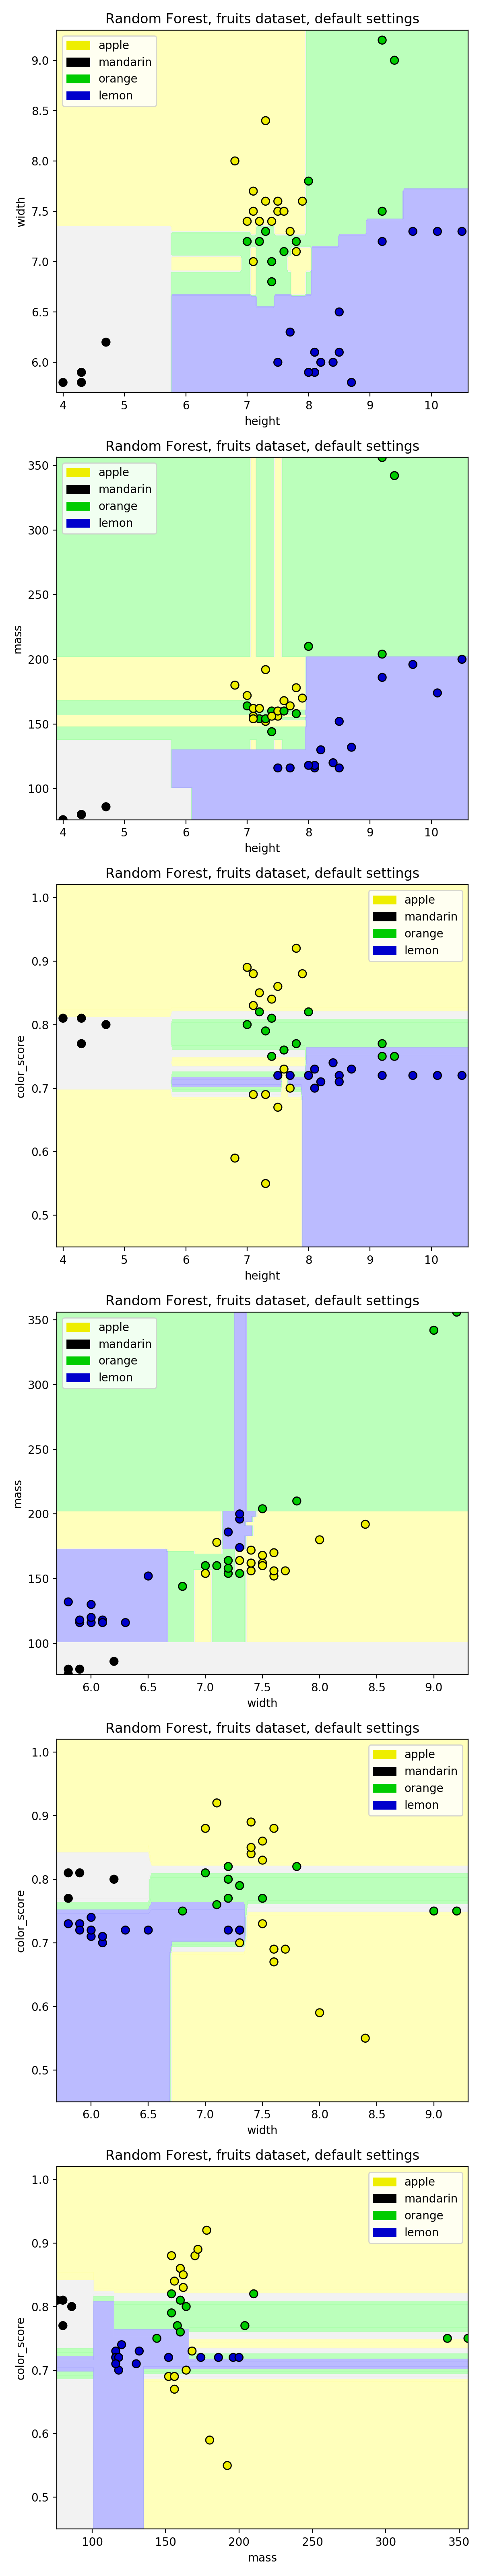

Random Forest, Fruit dataset, default settings
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.87


In [0]:
# Gradient boosted on Fruit dataset
X_fruits, y_fruits, X_fruits_2d, y_fruits_2d = load_fruit_dataset()
X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
feature_names_fruits = ['height', 'width', 'mass', 'color_score']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    gb = GradientBoostingClassifier().fit(X, y)
    plot_class_regions_subplot(gb, X, y, None,
                                None, title, axis,
                                target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
plt.tight_layout()
plt.show()

gb = GradientBoostingClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(gb.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(gb.score(X_test, y_test)))


In [0]:
# Gradient-boosted decision trees on a real-world dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = load_breast_cancer(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

gb = GradientBoostingClassifier(random_state = 0)
gb.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.1, max_depth=3)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(gb.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(gb.score(X_test, y_test)))

gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(gb.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(gb.score(X_test, y_test)))

Breast cancer dataset (learning_rate=0.1, max_depth=3)
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.96

Breast cancer dataset (learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.97
Accuracy of GBDT classifier on test set: 0.97


<h2>Neural Nets</h2>

**Activation functions**

<IPython.core.display.Javascript object>


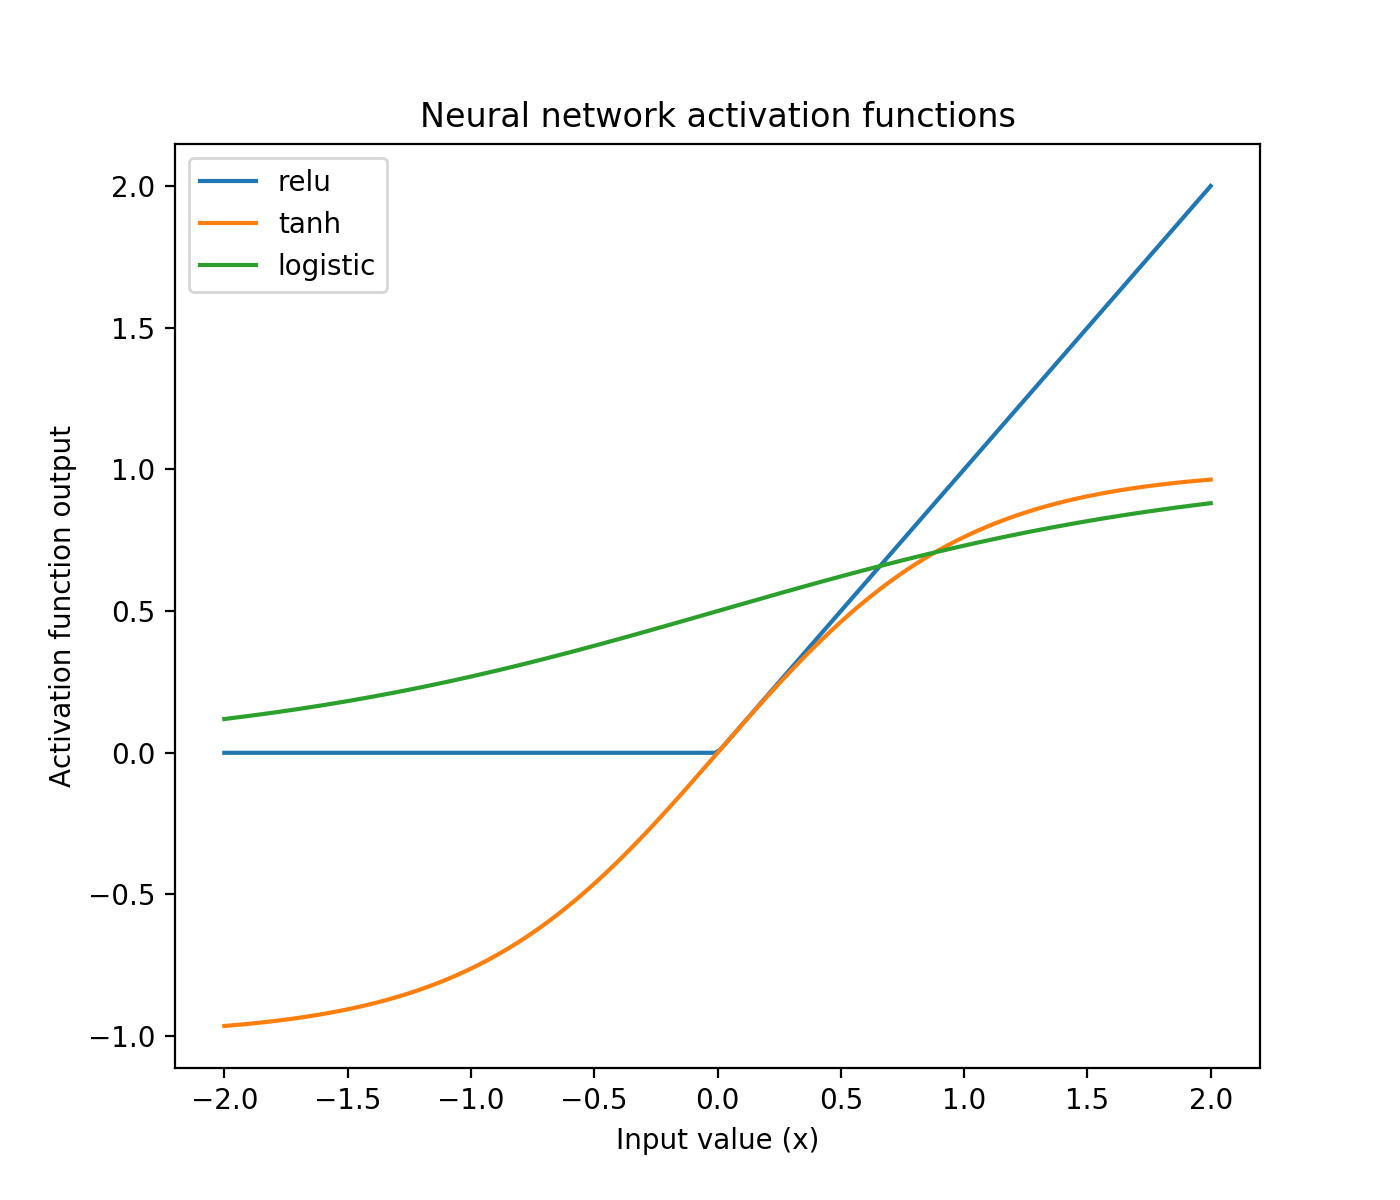

In [0]:
xrange = np.linspace(-2, 2, 200)

plt.figure(figsize=(7,6))

plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1+np.exp(-xrange)), label = 'logistic')

plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

<IPython.core.display.Javascript object>


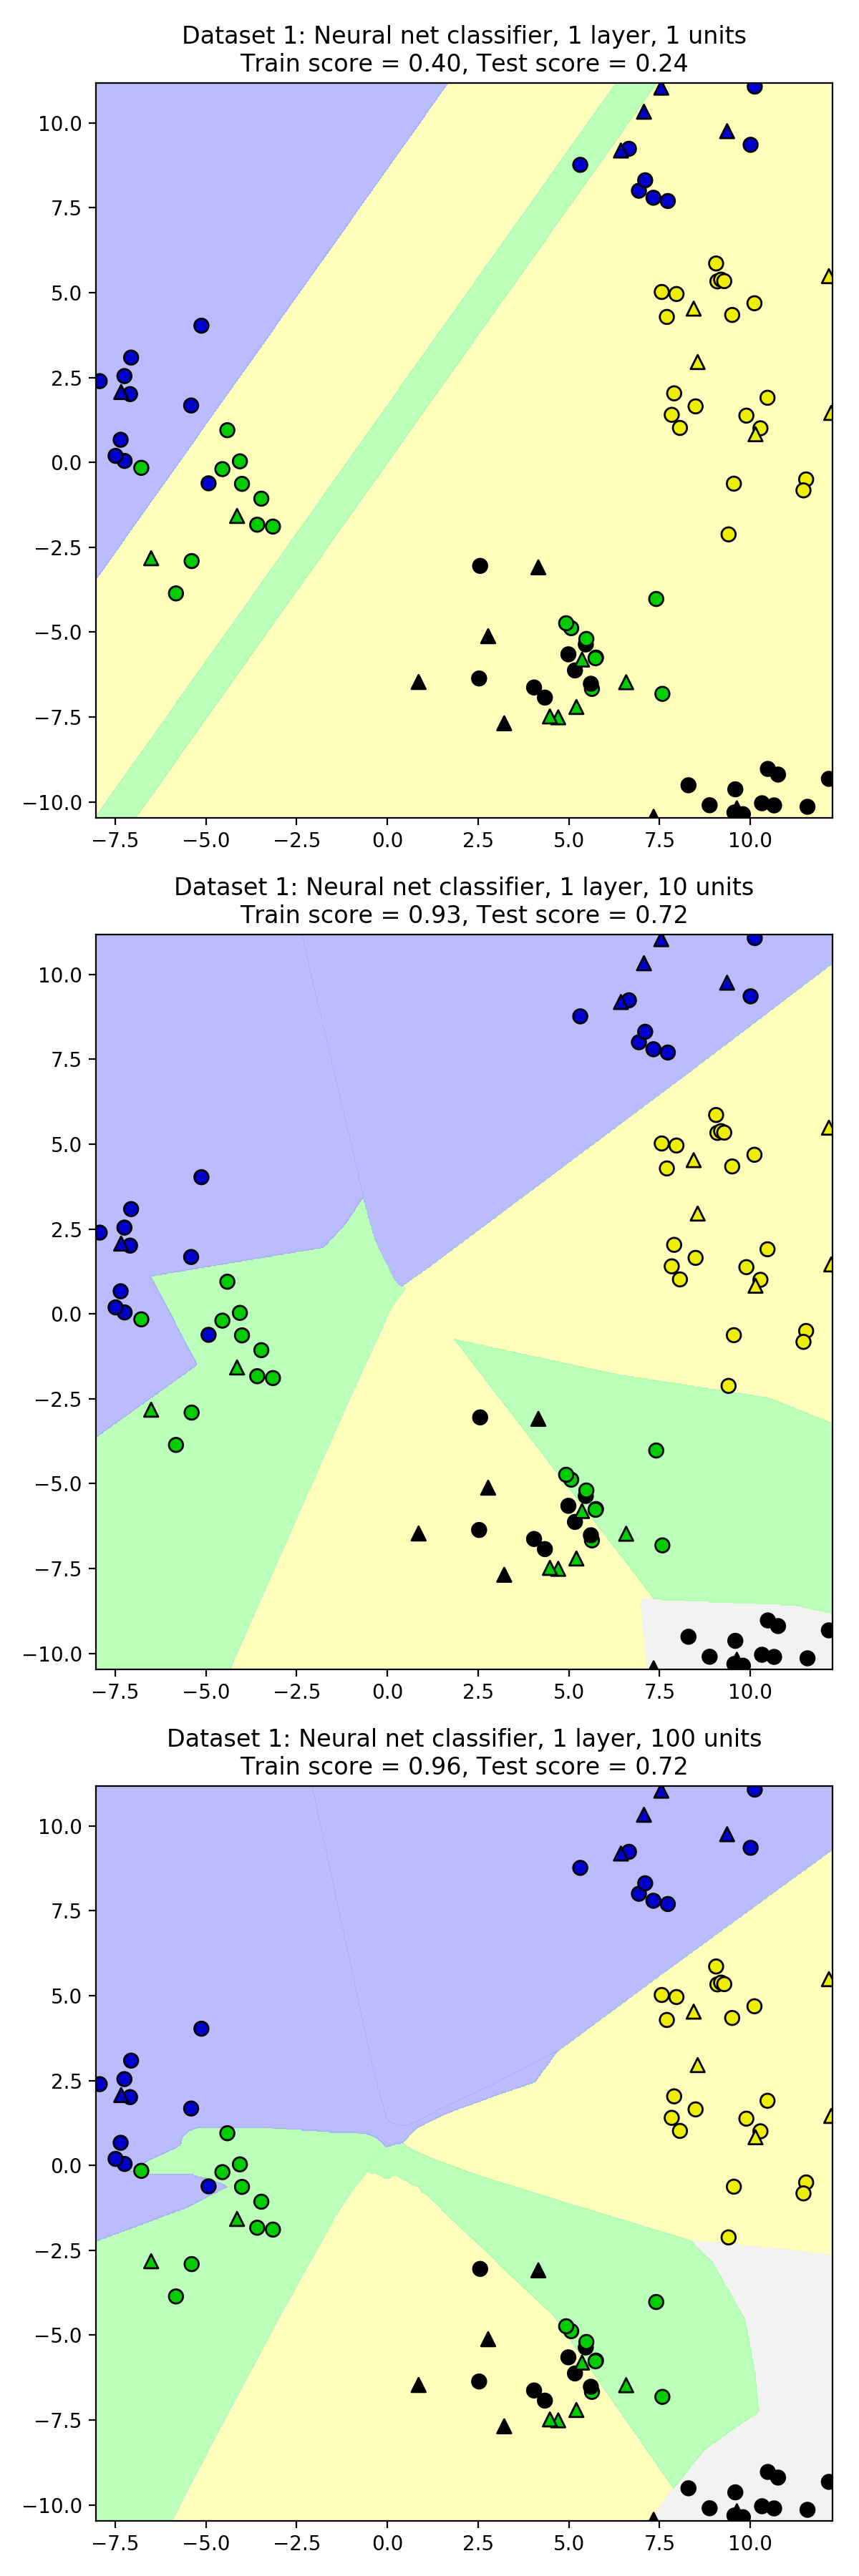

In [0]:
from sklearn.neural_network import MLPClassifier   # load MultiLinePerceptron class
from sklearn.datasets import make_classification, make_blobs
# get data
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                    random_state=0)
fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# NN
# the number of hidden layer and hidden units increase model comlexity

for units, axis in zip([1, 10, 100], subaxes):
    nn_clf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_subplot(nn_clf, X_train, y_train,
                               X_test, y_test, title, axis)
    plt.tight_layout()
#     plt.show()

#### Two hidden layers MLP model


<IPython.core.display.Javascript object>


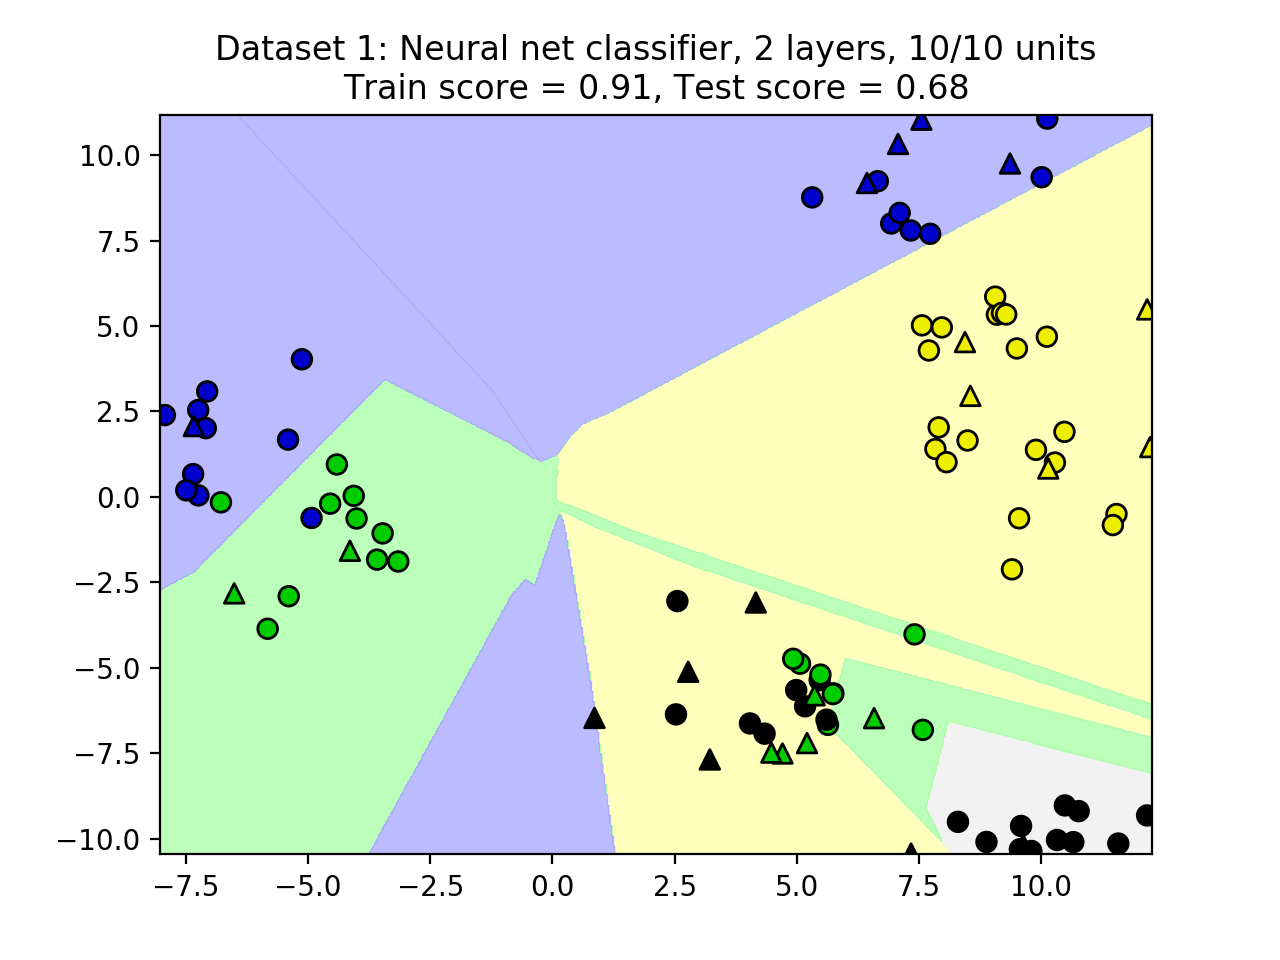

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

nn_clf = MLPClassifier(hidden_layer_sizes=[10, 10], solver='lbfgs',
                      random_state = 0).fit(X_train, y_train)
plot_class_regions_for_classifier(nn_clf, X_train, y_train, X_test, y_test,
                           'Dataset 1: Neural net classifier, 2 layers, 10/10 units')


### Regularization parameter: alph

<IPython.core.display.Javascript object>


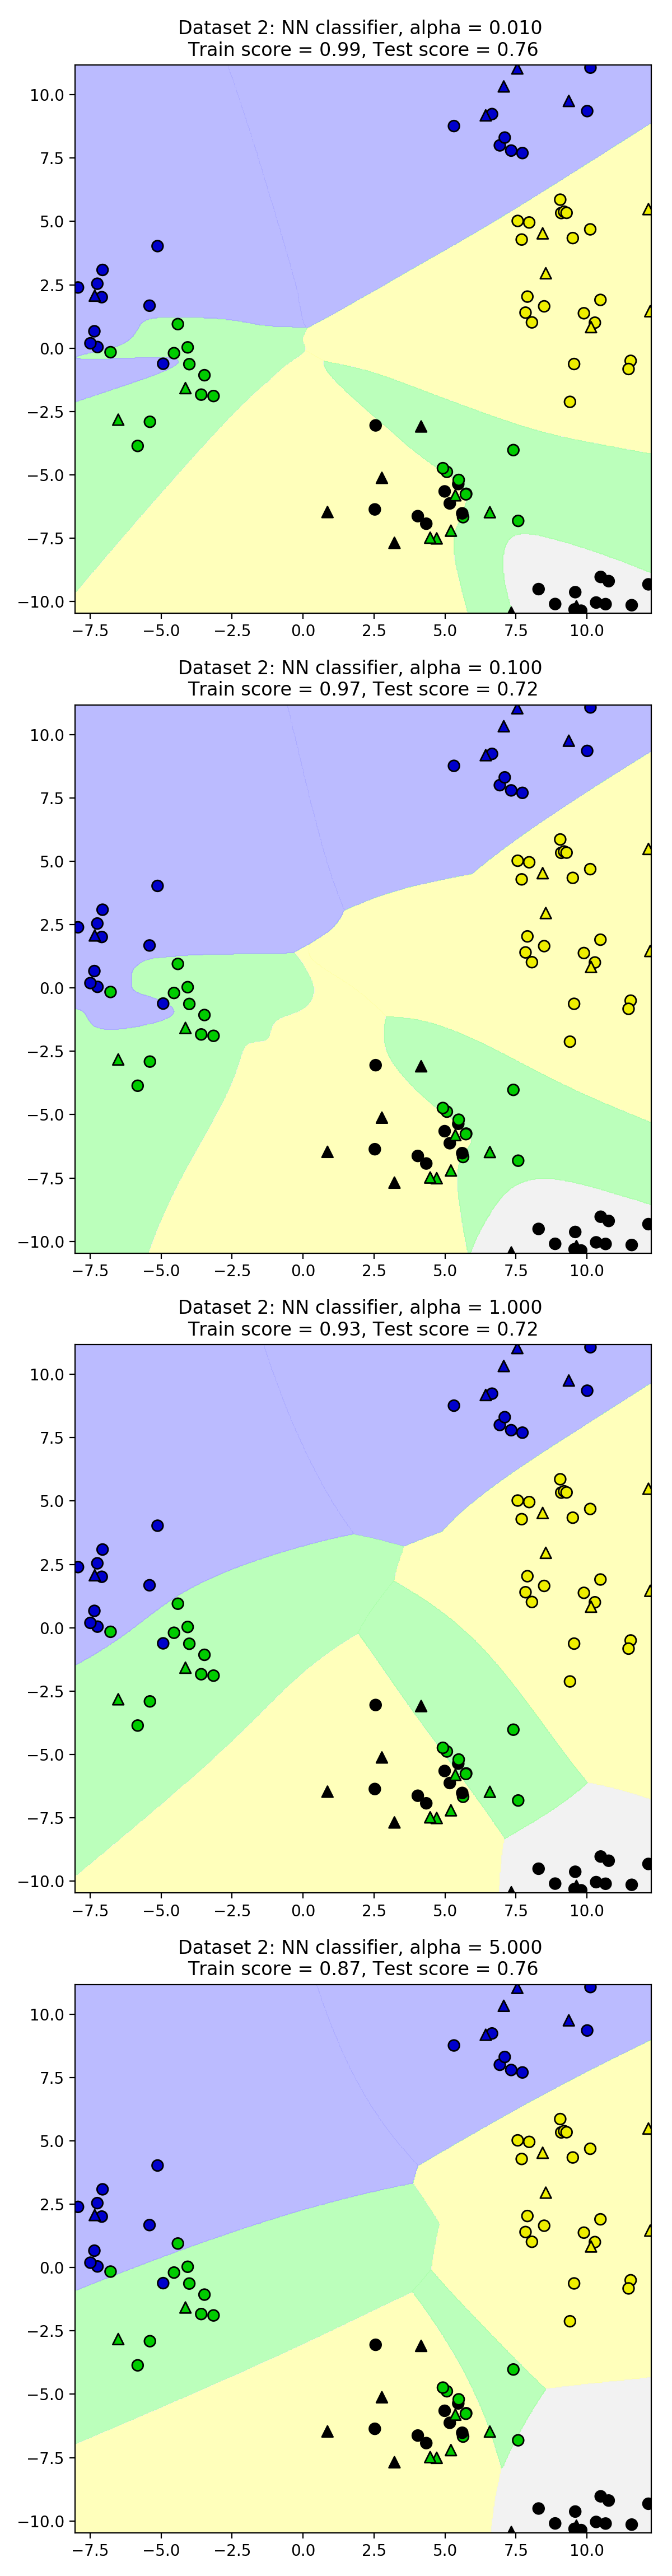

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

# increasing alpha increase regularization-- simplify model complexity
# and avoid overfitting
for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Application of MLP for real-world proble 

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cancer = load_breast_cancer()
X_cancer, y_cancer = load_breast_cancer(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)
# normalize  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)    # transformation is done afte fitting the scaler with train data

# create nn with two hidden alyer of 100 units
nn_clf = MLPClassifier(hidden_layer_sizes= [100, 100], alpha=5.0,
                      random_state=0, solver='lbfgs').fit(X_train_scaled, y_train)
print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(nn_clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(nn_clf.score(X_test_scaled,y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


### The effect of different choices of activation function

<IPython.core.display.Javascript object>


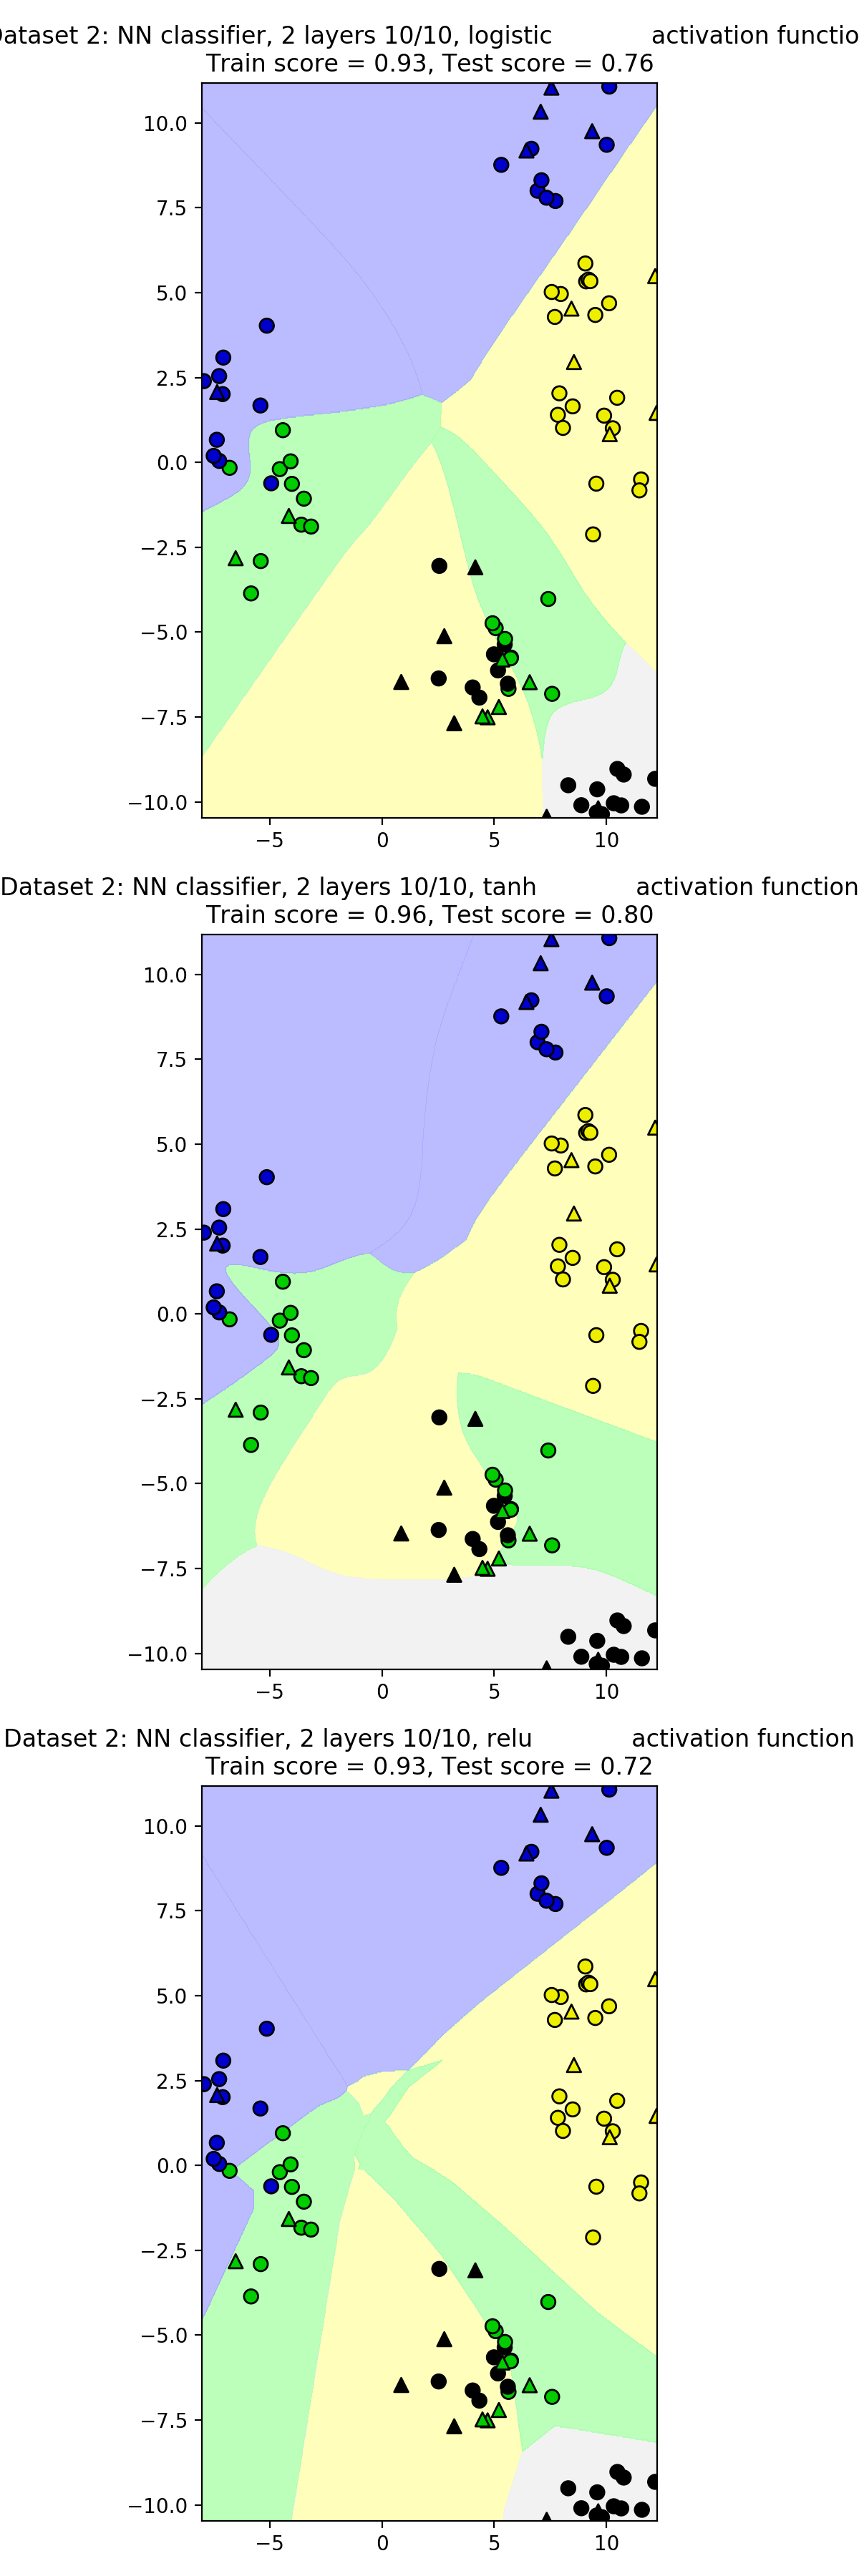

In [0]:
fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# loop throught di
for this_activation, axis in zip(['logistic', 'tanh', 'relu'], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation=this_activation, 
                          alpha = 0.1, hidden_layer_sizes=[10,10],
                          random_state=0).fit(X_train, y_train)
   
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
            activation function'.format(this_activation)
    
    plot_class_regions_subplot(nnclf, X_train, y_train,
                              X_test, y_test, title, axis)
    plt.tight_layout()
    

### Neural Networks: Regresssion

<IPython.core.display.Javascript object>


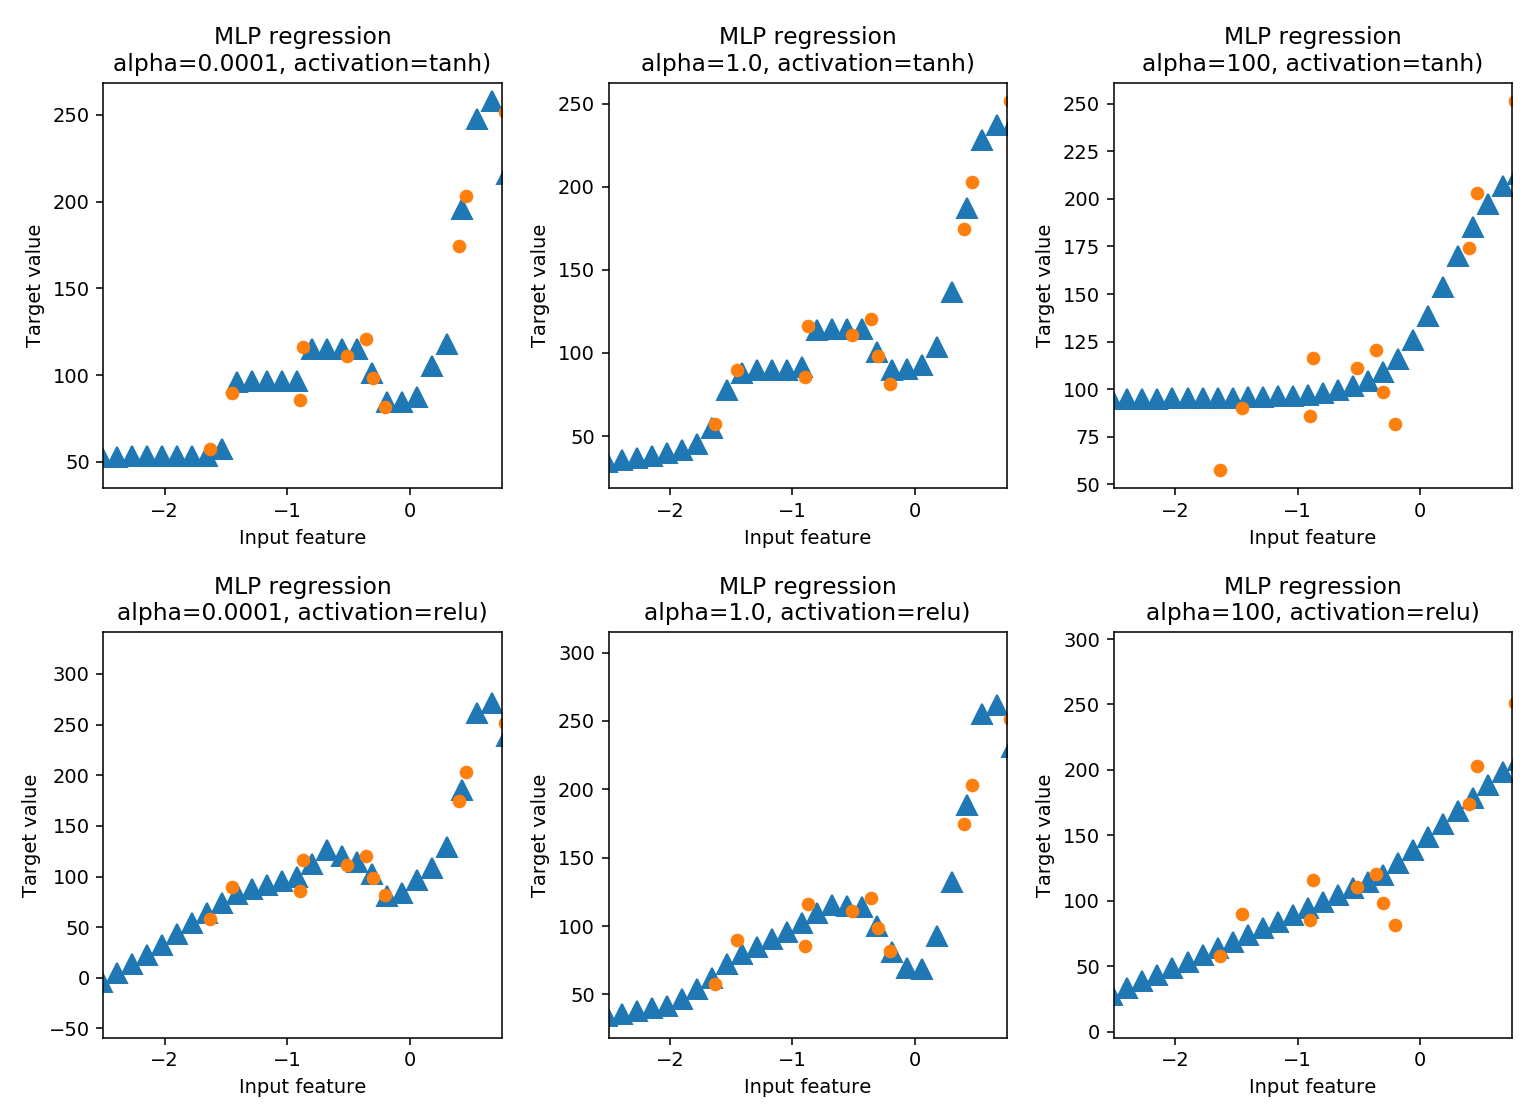

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], 
                                                    random_state = 0)
for this_axis_row, this_activation in zip(subaxes, ['tanh', 'relu']):
    for this_alpha, this_axis in zip([0.0001, 1.0, 100], this_axis_row):
        mlp_reg = MLPRegressor(hidden_layer_sizes=[100, 100],
                              activation=this_activation,
                              alpha = this_alpha,
                              solver='lbfgs').fit(X_train, y_train)
        y_predict_output = mlp_reg.predict(X_predict_input)
        this_axis.set_xlim([-2.5, 0.75])
        this_axis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        this_axis.plot(X_train, y_train, 'o')
        this_axis.set_xlabel('Input feature')
        this_axis.set_ylabel('Target value')
        this_axis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(this_alpha, this_activation))
        plt.tight_layout()



**Observation:**
- Here we've included regression results that use, in the top row, the `hyperbolic tangent` activation function. And in the bottom row, the `relu` activation function. 

- the smoothness of the activation function influences the smoothness of the corresponding regression results. 

- Along the columns, the plots also show the effect of using different alpha settings, to increase the amount of L2 regularization from left to right. 

- Again, as with classification, the effect of increasing the amount of L2 regularization, by increasing alpha. Is to constrain the regression to use simpler and simpler models, with fewer and fewer large weights. 

Note: This tutorial took significant inspiration from the from `Applied Machine Learning in Python` by Mchicagan State on Coursera